In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [ ]:
data = pd.read_csv(r'C:\Users\giuli\Documents\GitHub\Progetto_BI2021\data.csv', parse_dates=['created_at'])
df = pd.DataFrame(data)

## DECODING DEL TESTO ALL INTERNO DELLA COLONNA `text`. 
All interno della colonna text è presente una rappresentazione di un bytes sotto forma di stringa. Questa può essere valutata attraverso la funzione `ast.literal_eval(string)` e quindi decodificata
#secondo la codifica appropriata tramite il metodo decode

In [ ]:
text_enc = []
for i in range(0, df.text.size):
    txt= ast.literal_eval(df.text[i]).decode('utf-8')
    text_enc.append(txt)

df['text_enc'] = text_enc
df

## Pulizia dei Tweet
Attraverso le Regular Expressions vado a rimuovere elementi come:
* @menzioni
* Hashtag
* Link

In [ ]:
import re

def cleanTxt(text):
 text=text.lower()
 text = re.sub('\S*trump\S*', 'trump', text)
 text = re.sub('\S*biden\S*', 'biden', text)
 text = re.sub('\S*clinton\S*', 'clinton', text)
 text = re.sub('@\S+', '', text) #Rimuove le @menzioni
 text = re.sub('#', '', text) # Rimuove l'hashtag
 text = re.sub('https?:\/\/\S+', '', text) # Rimuove i link
 text = re.sub('&amp', '', text) #Rimuove &amp
 text = re.sub('covid-19', 'covid', text ) #converte covid-19 in covid
 text = re.sub('covid19', 'covid', text ) #converte covid19 in covid
 text = re.sub('covid 19', 'covid', text ) #converte covid 19 in covid
 text = re.sub('coronavirus', 'covid', text)
 return text

def countMentions(text):
    return len(re.findall('@\S+', text))

def countHashtags(text):
    return len(re.findall('#', text))

def countLinks(text):
    return len(re.findall('https?:\/\/\S+', text))


df.text_enc=df.text_enc.astype('str')
df['text_clean'] = df.text_enc.apply(cleanTxt)
df['mentions'] = df.text_enc.apply(countMentions)
df['hashtags'] = df.text_enc.apply(countHashtags)
df['links'] = df.text_enc.apply(countLinks)


In [ ]:
df

## Language Detection
il metodo `detect_langs` fornisce un vettore di possibilità riguardo la lingua del testo che sta analizzando. Vado a vedere se ci sono nel dataset testi ambigui (quindi quelli per cui la dimensione del `dict` ritornato da `detect_langs` è maggiore di 1).

Utilizzo `langdetect` che è abbastanza veloce per generare una previsione sommaria. Esso restituisce la probabilità per ciascuna lingua trovata quindi:
* se trovo una sola lingua tra quelle ammesse (en, es, fr) allora segno la lingua trovata e segno la detection come sicura
* se trovo più di una lingua oppure trovo come lingua più probabile una non ammessa segno la lingua e segno la detection come insicura/sbagliata (`unsure_wrong_detection=True`) 

In [ ]:
from langdetect import detect_langs

unsure_count = 0
wrong_count = 0
i=0
lang_detect = []
unsure_wrong = []

for twt in df.text_enc:
    try:
        detection = detect_langs(twt)
        lang = detection[0].lang
        
        lang_detect.append(lang)
        unsure_wrong.append(False)
        
        if((lang != "en") and (lang != "es") and (lang != "fr")):
             wrong_count = wrong_count +1
             unsure_wrong[i]=True
        if(len(detection)>1):
            unsure_wrong[i]=True
            unsure_count = unsure_count+1

    except:
        print("errore alla posizione ")
        i
        print("testo : " + twt)
        lang_detect.append('None')
        unsure_wrong.append(True)

    i=i+1



df['langdetect']=lang_detect
df['unsure_wrong_detection'] = unsure_wrong

unsure_wrong_sum = df['unsure_wrong_detection'].sum()
unsure_wrong_sum

# Check traduzione attraverso API Google 
I tweet dei quali la traduzione non è sicura sono stati marcati con un `True` all'interno della colonna `unsure_wrong_detection`. Utilizzo questa informazione per passare i questi tweet all'interno dell'API Google per la traduzione. Questo metodo non è stato utilizzato prima in quanto le possibili chiamate ai server Google sono limitate e molto lente.

In [ ]:
from textblob import TextBlob

lang_detect_final = []
i = 0
for twt in df.text_clean:
    if not df['unsure_wrong_detection'][i]:
        lang_detect_final.append(df['langdetect'][i])
    else:
        blob = TextBlob(twt)
        lang = blob.detect_language()
        if((lang != "en") and (lang != "es") and (lang != "fr")):
            lang_detect_final.append('None')
        else:
            lang_detect_final.append(lang)
            df['unsure_wrong_detection'][i]=False
    i=i+1

df['lang_detect_final'] = lang_detect_final

In [ ]:
df.unsure_wrong_detection.sum()

## Esportazione dei dati su formato Excel
Excel non supporta le date con le timezone quindi le ho dovute eliminare con il metodo `datetime.tz_localize()`

In [ ]:
df_enc = df[['favorite_count', 'source', 'text_enc', 'text_clean', 'is_retweet', 'retweet_count', 'created_at', 'langdetect' , 'unsure_wrong_detection', 'lang_detect_final']]
df_enc.loc[:,'created_at_ntz']= df_enc.created_at.dt.tz_localize(None)

df_enc = df_enc.drop(columns='created_at')
df_enc.to_excel('data_dec.xlsx')

# Inizio dell'analisi
Dopo aver salvato i dati ripuliti all'interno del file Excel, uso questo come checkpoint per partire con l'analisi. Questo perché non è sempre possibile performare di nuovo la traduzione a causa delle restrizioni dell'api di Google descritte sopra

Dal momento che i Tweet la cui lingua non è stata riconosciuta sono meno dell' 1%, questi vengono filtrati. Dopodiché il dataset viene splittato per lingua in tre ```DataFrame``` 


In [ ]:
data=pd.read_excel(r'C:\Users\giuli\Documents\GitHub\Progetto_BI2021\data_dec.xlsx')
df=pd.DataFrame(data)

df = df.drop(columns='langdetect')
df.loc[df['unsure_wrong_detection']==True].shape #controllo dei tweet la cui lingua non è stata riconosciuta
df = df.loc[df['unsure_wrong_detection']==False] #filtraggio dei tweet non riconosciuti

### Suddivisione dei Dataset per lingua ###

#en
df_en = df.loc[df['lang_detect_final']=='en']
df_en = df_en.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#es
df_es = df.loc[df['lang_detect_final']=='es']
df_es = df_es.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#fr
df_fr = df.loc[df['lang_detect_final']=='fr']
df_fr = df_fr.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])


In [ ]:
#questo blocco di codice è inutile se si fanno runnare tutti i blocchi dall'inizio

df_en.text_enc=df_en.text_enc.astype('str')
df_en['text_clean'] = df_en.text_enc.apply(cleanTxt)
df_en['mentions'] = df_en.text_enc.apply(countMentions)
df_en['hashtags'] = df_en.text_enc.apply(countHashtags)
df_en['links'] = df_en.text_enc.apply(countLinks)

df_en.to_excel('dataen.xlsx')

In [ ]:
df_en

## Preprocessing del testo
Attraverso la libreria ```nltk``` viene effettuato il preprocessing del testo. Ogni tweet viene tokenizzato in parole che vengono filtrate dalle stopwords e stemmate attraverso il ```PorterStemmer```. I tweet, una volta stemmati vengono salvati nella colonna text_stem e quindi per comodità de-tokenizzati.

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

df_en.text_clean=df_en.text_clean.astype('str')

text_stem = []
#df_en['text_clean']=df_en['text_clean'].astype('str')

for twt in df_en.text_clean:
    tweet = twt.lower()
    token_words = word_tokenize(tweet) #tokenizzazione
    token_filter_words = [w for w in token_words if not w in stop_words] #stopword filtering
    stem_sentence=[]
    for word in token_filter_words:
        stem_sentence.append(porter.stem(word)) #stemming
        stem_sentence.append(' ')
    
    text_stem.append(''.join(stem_sentence))

df_en['text_stem']=text_stem

## Tf-Idf
A questo punto viene performata la Tf-Idf sui tweet stemmati al punto precedenti. Per comodità di visualizzazione viene creato un dataframe per visualizzare la matrice tf-idf e generare una classifica delle parole: lo score di ciascuna parola è la media del tf-idf della parola in tutti i tweet. Vengono visualizzati i termini con score maggiore.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(min_df=0.005, #max_df=0.1,
                                 stop_words='english')
tfidf_en_matrix = tfidfVectorizer.fit_transform(df_en.text_stem)

## Conversione TfIdf in Dataframe ##

# tfidfVectorizer ritorna una matrice sparsa che non permette la visualizzazione agevole della matrice TfIdf

tf_idf_en = pd.DataFrame(columns=tfidfVectorizer.get_feature_names(), index=df_en.text_clean, dtype=float)

M = tfidf_en_matrix.todense()
for i in range(0, df_en.shape[0]):
    tf_idf_en.iloc[i, :]=M[i,:]

## classifica delle parole
score={}
for word in tfidfVectorizer.get_feature_names():
    score[word]= tf_idf_en[word].mean()

score_sroted = dict(sorted(score.items(), key=lambda item: item[1], reverse=True))
list(score_sroted.items())[0:30]

[('covid', 0.10713194782993343),
 ('vaccin', 0.058122695421392194),
 ('new', 0.021349394159538973),
 ('pandem', 0.020707242511844585),
 ('peopl', 0.020353897993066257),
 ('case', 0.020313515213253162),
 ('death', 0.015557672891619852),
 ('year', 0.01501610345522534),
 ('test', 0.014675804381406308),
 ('time', 0.014508192720551582),
 ('news', 0.01407798232284183),
 ('health', 0.01391751973170271),
 ('state', 0.01384335974872097),
 ('make', 0.013041164579905225),
 ('say', 0.012915906497732632),
 ('mask', 0.012819465858309422),
 ('need', 0.01271815717760838),
 ('report', 0.012272768985682178),
 ('help', 0.011765874383629816),
 ('texa', 0.011570939248291955),
 ('like', 0.011355713190842569),
 ('march', 0.01132052838708476),
 ('live', 0.010873217372781767),
 ('work', 0.010318211172297415),
 ('relief', 0.01027424764275148),
 ('week', 0.009884135578162749),
 ('school', 0.009747697199553542),
 ('know', 0.009662962551310338),
 ('day', 0.009622297445567815),
 ('updat', 0.009351504693779033)]

## Prova di Feature reduction
Provo a ridurre le features non alla cieca come il parametro ```min_df``` della Tf Idf ma preservando le informazioni all'interno del dataset.
La PCA è giustificata dalla non necessità di interpretare le feature.

411 3
<ipython-input-45-39ac5aeed0e6>:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure)


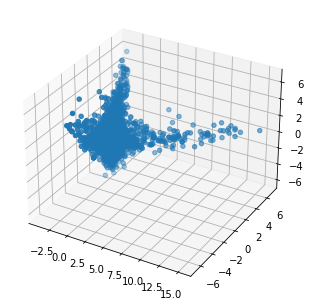

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Standardizzo i dati
scaler = StandardScaler()
M= scaler.fit_transform(M)

#Applico la PCA mantenendo il 95% della varianza
pca=PCA(n_components=3)
M = pca.fit_transform(M)

print(tf_idf_en.shape[1], pca.n_components_)

#scatter 3d dei centroidi prodotti
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

figure = pyplot.figure()
ax = Axes3D(figure)

ax.scatter(M[:,0], M[:,1], M[:,2])
pca.explained_variance_

pyplot.show()

# K-means Clustering
Viene performato un algoritmo di K-means Clustering, valutando i valori di K e plottando la Sum of Square Differences.

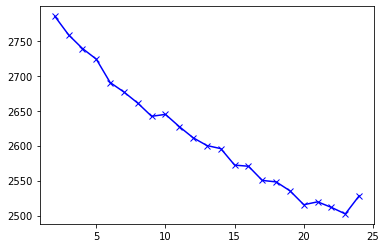

In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

SSD = []
K=range(2,25)

for k in K:
    km=KMeans(n_clusters=k, max_iter=300, n_init=20)
    km = km.fit(tfidf_en_matrix)
    SSD.append(km.inertia_)

plt.plot(K, SSD, 'bx-')

In [ ]:
SSD

Si sceglie un valore di k=5, si performa il clustering e si aggiunge l'informazione di labeling al dataframe

In [18]:
k=20

model = KMeans(n_clusters=k, max_iter=300, n_init=20)
model.fit(tfidf_en_matrix)

df_en['label_kmeans']=model.labels_


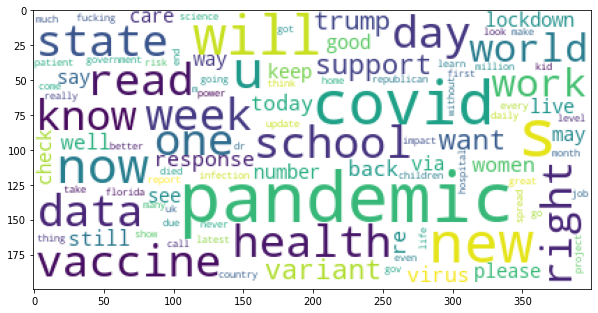

In [20]:

from wordcloud import WordCloud

frequent_words=['covid']

df_en_0 = df_en.loc[df_en['label_kmeans']==1]
text = df_en_0['text_clean'].str.cat(sep='')
text = text.lower()
text=' '.join([word for word in text.split() if not word in frequent_words])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig1 = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)

## Esaminazione dei cluster

<ipython-input-46-108b1f207c08>:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure)


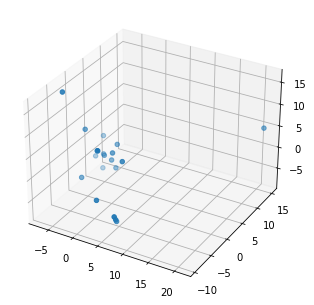

In [46]:
#visualizzazione dei centroidi tramite PCA

M = model.cluster_centers_

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Standardizzo i dati
scaler = StandardScaler()
M = scaler.fit_transform(M)

#Applico la PCA mantenendo le prime 3 componenti
pca=PCA(n_components=3)
M = pca.fit_transform(M)

#scatter 3d dei centroidi prodotti
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

figure = pyplot.figure()
ax = Axes3D(figure)

ax.scatter(M[:,0], M[:,1], M[:,2])
pca.explained_variance_

pyplot.show()

In [38]:
pip install mpl_toolkits

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits
You should consider upgrading via the 'C:\Users\giuli\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


# DB Scan Clustering

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1).fit(M)


df_en['labels_DBSCAN']= clustering.labels_



In [ ]:
df_en.loc[df_en['labels_DBSCAN']==-1]

In [ ]:
from wordcloud import WordCloud

df_en_0 = df_en.loc[df_en['labels_DBSCAN']==4]
text = df_en_0['text_clean'].str.cat(sep='')
text = text.lower()
text=' '.join([word for word in text.split()])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig1 = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)

In [ ]:
pip install wikipedia